<a href="https://colab.research.google.com/github/Mattia-Colbertaldo/PrimacyRL/blob/main/dopamine_prl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General information on the execution on the Notebook
- The notebook is designed to be executed with a GPU activated but will work without
- The notebook should ***never*** be run with _run all_, as the exectution time can be extremely high and the notebook might request session restarts!


In [ ]:
# @title Installation of packages and games (might be unused)
!pip install atari-py
!pip install ale-py
!pip install mujoco-py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.6/540.6 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for atari-py: filename=atari_py-0.2.9-cp310-cp310-linux_x86_64.whl size=2871208 sha256=58bbc42962acbae5291c240660c801d24639d334f0af2fad1ea4d14685eb1e27
  Stored in directory: /root/.cache/pip/wheels/75/6f/04/1f3bf5255580101e16ff487564354dddcdd23ec3b43b775b7a
Successfully built atari-py
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.2/208.2 kB 15.9 MB/s eta 0:00:00


In [ ]:
# @title Install Dopamine from source
!git clone https://github.com/google/dopamine
!pip install -r dopamine/requirements.txt

# Install the dopamine package itself (required as there might be previous unseen instalations)
%cd dopamine
!pip install .
%cd ..

Cloning into 'dopamine'...
remote: Enumerating objects: 3989, done.
remote: Counting objects: 100% (1467/1467), done.
remote: Compressing objects: 100% (317/317), done.
remote: Total 3989 (delta 1168), reused 1150 (delta 1150), pack-reused 2522
Receiving objects: 100% (3989/3989), 21.12 MiB | 16.79 MiB/s, done.
Resolving deltas: 100% (2663/2663), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 529.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 854.7/854.7 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 40.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-a

In [ ]:
# @title Import dependencies and set up base path
import numpy as np
import os
#import gin
#gin.enter_interactive_mode()
from dopamine.discrete_domains import run_experiment
from dopamine.colab import utils as colab_utils
from absl import flags
import gin.tf

BASE_PATH = '/tmp/colab_dopamine_run'  # @param

/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/dtypes.py:35: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  from tensorflow.tsl.python.lib.core import pywrap_ml_dtypes
/usr/local/lib/python3.10/dist-packages/gin/tf/__init__.py:48: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <
/usr/local/lib/python3.10/dist-packages/flax/linen/module.py:77: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr, jax.dtypes.prng_key) for runtime detection of typed prng keys.
  KeyArray = Union[jax.Array, jax.random.KeyArray]  # pylint: disable=invalid-name
/usr/local/lib/python3.10/dist-packages/flax/linen/recurrent.py:45: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr, jax.dtypes.prng_key) for runtime detect

# Cartpole with two Agents

In [ ]:
DQN_PATH = os.path.join(BASE_PATH, 'cartpole/dqn')
# Modified from dopamine/agents/dqn/config/dqn_cartpole.gin
dqn_config = """
# Hyperparameters for a simple DQN-style Cartpole agent. The hyperparameters
# chosen achieve reasonable performance.
import dopamine.discrete_domains.gym_lib
import dopamine.discrete_domains.run_experiment
import dopamine.agents.dqn.dqn_agent
import dopamine.replay_memory.circular_replay_buffer
import gin.tf.external_configurables

DQNAgent.observation_shape = %gym_lib.CARTPOLE_OBSERVATION_SHAPE
DQNAgent.observation_dtype = %gym_lib.CARTPOLE_OBSERVATION_DTYPE
DQNAgent.stack_size = %gym_lib.CARTPOLE_STACK_SIZE
DQNAgent.network = @gym_lib.CartpoleDQNNetwork
DQNAgent.gamma = 0.99
DQNAgent.update_horizon = 1
DQNAgent.min_replay_history = 500
DQNAgent.update_period = 4
DQNAgent.target_update_period = 100
DQNAgent.epsilon_fn = @dqn_agent.identity_epsilon
DQNAgent.tf_device = '/gpu:0'  # use '/cpu:*' for non-GPU version
DQNAgent.optimizer = @tf.train.AdamOptimizer()

tf.train.AdamOptimizer.learning_rate = 0.001
tf.train.AdamOptimizer.epsilon = 0.0003125

create_gym_environment.environment_name = 'CartPole'
create_gym_environment.version = 'v1'
create_agent.agent_name = 'dqn'
TrainRunner.create_environment_fn = @gym_lib.create_gym_environment
Runner.num_iterations = 50
Runner.training_steps = 1000
Runner.evaluation_steps = 1000
Runner.max_steps_per_episode = 1000  # Default max episode length.

WrappedReplayBuffer.replay_capacity = 50000
WrappedReplayBuffer.batch_size = 128
"""
gin.parse_config(dqn_config, skip_unknown=False)

([],
 ['dopamine.discrete_domains.gym_lib',
  'dopamine.discrete_domains.run_experiment',
  'dopamine.agents.dqn.dqn_agent',
  'dopamine.replay_memory.circular_replay_buffer',
  'gin.tf.external_configurables'])

In [ ]:
# @title Train DQN on Cartpole
dqn_runner = run_experiment.create_runner(DQN_PATH, schedule='continuous_train')
print('Will train DQN agent, please be patient, may be a while...')
dqn_runner.run_experiment()
print('Done training!')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
Instructions for updating:
non-resource variables are not supported in the long term


Will train DQN agent, please be patient, may be a while...


Instructions for updating:
Use standard file APIs to delete files with this prefix.


Done training!


In [ ]:
# @title Load the configuration for C51.

C51_PATH = os.path.join(BASE_PATH, 'cartpole/c51')
# Modified from dopamine/agents/rainbow/config/c51_cartpole.gin
c51_config = """
# Hyperparameters for a simple C51-style Cartpole agent. The hyperparameters
# chosen achieve reasonable performance.
import dopamine.agents.dqn.dqn_agent
import dopamine.agents.rainbow.rainbow_agent
import dopamine.discrete_domains.gym_lib
import dopamine.discrete_domains.run_experiment
import dopamine.replay_memory.prioritized_replay_buffer
import gin.tf.external_configurables

RainbowAgent.observation_shape = %gym_lib.CARTPOLE_OBSERVATION_SHAPE
RainbowAgent.observation_dtype = %gym_lib.CARTPOLE_OBSERVATION_DTYPE
RainbowAgent.stack_size = %gym_lib.CARTPOLE_STACK_SIZE
RainbowAgent.network = @gym_lib.CartpoleRainbowNetwork
RainbowAgent.num_atoms = 51
RainbowAgent.vmax = 10.
RainbowAgent.gamma = 0.99
RainbowAgent.update_horizon = 1
RainbowAgent.min_replay_history = 500
RainbowAgent.update_period = 4
RainbowAgent.target_update_period = 100
RainbowAgent.epsilon_fn = @dqn_agent.identity_epsilon
RainbowAgent.replay_scheme = 'uniform'
RainbowAgent.tf_device = '/gpu:*'  # use '/cpu:*' for non-GPU version
RainbowAgent.optimizer = @tf.train.AdamOptimizer()

tf.train.AdamOptimizer.learning_rate = 0.001
tf.train.AdamOptimizer.epsilon = 0.0003125

create_gym_environment.environment_name = 'CartPole'
create_gym_environment.version = 'v0'
create_agent.agent_name = 'rainbow'
TrainRunner.create_environment_fn = @gym_lib.create_gym_environment
Runner.num_iterations = 50
Runner.training_steps = 1000
Runner.evaluation_steps = 1000
Runner.max_steps_per_episode = 1000  # Default max episode length.

WrappedPrioritizedReplayBuffer.replay_capacity = 50000
WrappedPrioritizedReplayBuffer.batch_size = 128
"""
gin.parse_config(c51_config, skip_unknown=False)

([],
 ['dopamine.agents.dqn.dqn_agent',
  'dopamine.agents.rainbow.rainbow_agent',
  'dopamine.discrete_domains.gym_lib',
  'dopamine.discrete_domains.run_experiment',
  'dopamine.replay_memory.prioritized_replay_buffer',
  'gin.tf.external_configurables'])

In [ ]:
# @title Train C51 on Cartpole
c51_runner = run_experiment.create_runner(C51_PATH, schedule='continuous_train')
print('Will train agent, please be patient, may be a while...')
c51_runner.run_experiment()
print('Done training!')


/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


Will train agent, please be patient, may be a while...
Done training!


In [ ]:
# @title Load the training logs.
#data = colab_utils.read_experiment(DQN_PATH, verbose=True,
#                                   summary_keys=['train_episode_returns'])
#data['agent'] = 'DQN'
#data['run'] = 1

import collections
parameter_set = collections.OrderedDict([
    ('agent', ['DQN', 'C51']),
    ('game', ['Cartpole'])
])

data = colab_utils.read_experiment(DQN_PATH, verbose=True,
                                      parameter_set=parameter_set,
                              summary_keys=['train_episode_returns'])

datac51 = colab_utils.read_experiment(C51_PATH, verbose=True,
                                      parameter_set=parameter_set,
                              summary_keys=['train_episode_returns'])

datac51['agent'] = 'C51'
datac51['run'] = 1
data['agent'] = 'DQN'
data['run'] = 1

data = data.merge(datac51, how='outer')

Reading statistics from: /tmp/colab_dopamine_run/cartpole/dqn//logs/log_49
Reading statistics from: /tmp/colab_dopamine_run/cartpole/dqn//logs/log_49
Reading statistics from: /tmp/colab_dopamine_run/cartpole/c51//logs/log_49
Reading statistics from: /tmp/colab_dopamine_run/cartpole/c51//logs/log_49


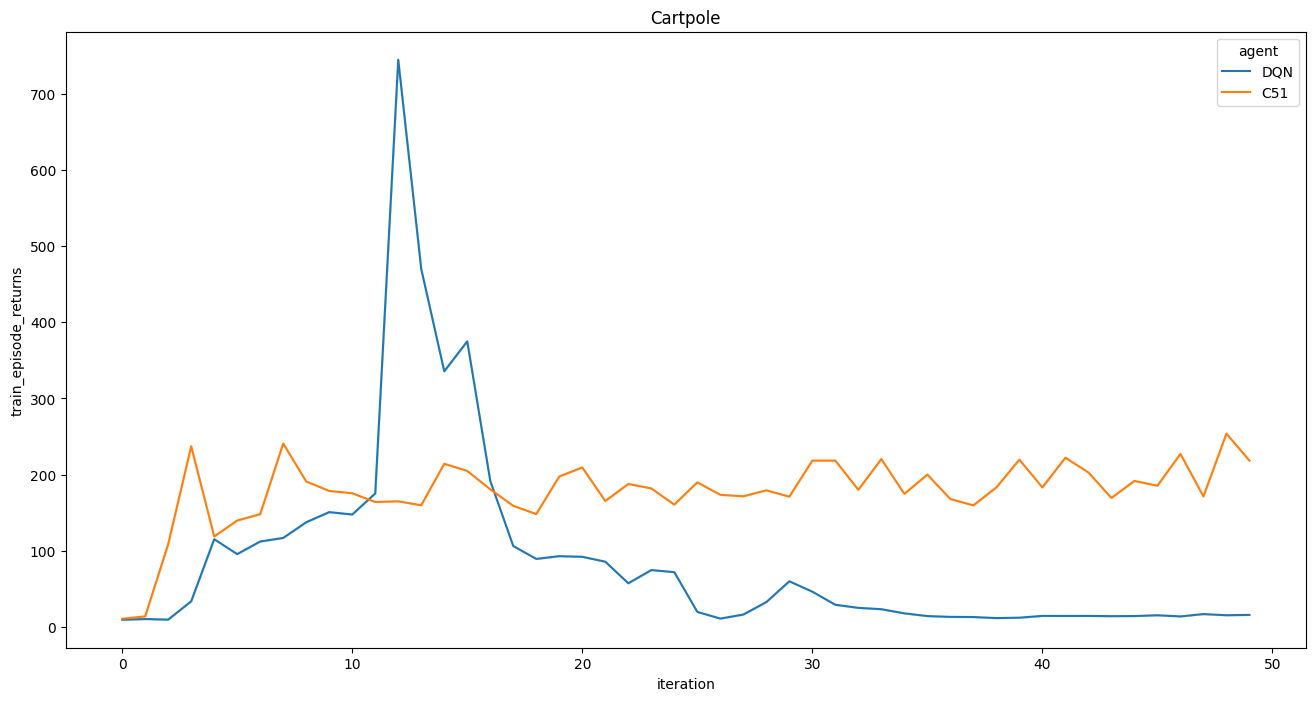

In [ ]:

#import seaborn as sns
#import matplotlib.pyplot as plt
#
#fig, ax = plt.subplots(figsize=(16,8))
#sns.lineplot(x='iteration', y='train_episode_returns', hue='agent',
#             data=data, ax=ax)
#plt.title('Cartpole')
#plt.show()

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(x='iteration', y='train_episode_returns', hue='agent',
              data=data, ax=ax)
plt.title('Cartpole')
plt.show()

In [ ]:
# @title Test with some integrated Libs
#from dopamine.utils.line_plotter import LinePlotter

In [ ]:
#def getData():
 # return np.asarray(data['train_episode_returns'])

#parameter_set = collections.OrderedDict([
#    ('get_line_data_fn', getData),
 #   ('agent', ['DQN', 'C51']),
 #   ('game', ['Cartpole'])
#])
#lp = LinePlotter(parameter_set)
#lp.draw()

# Acrobot

In [ ]:
# @title Load the configuration for DQN.

DQN_PATH = os.path.join(BASE_PATH, 'dqn')
# Modified from dopamine/agents/dqn/config/dqn_acrobot.gin
dqn_config = """
# Hyperparameters for a simple DQN-style Acrobot agent. The hyperparameters
# chosen achieve reasonable performance.
import dopamine.agents.dqn.dqn_agent
import dopamine.agents.rainbow.rainbow_agent
import dopamine.discrete_domains.gym_lib
import dopamine.discrete_domains.run_experiment
import dopamine.replay_memory.prioritized_replay_buffer
import gin.tf.external_configurables

RainbowAgent.observation_shape = %gym_lib.ACROBOT_OBSERVATION_SHAPE
RainbowAgent.observation_dtype = %gym_lib.ACROBOT_OBSERVATION_DTYPE
RainbowAgent.stack_size = %gym_lib.ACROBOT_STACK_SIZE
RainbowAgent.network = @gym_lib.AcrobotRainbowNetwork
RainbowAgent.num_atoms = 51
RainbowAgent.vmax = 10.
RainbowAgent.gamma = 0.99
RainbowAgent.update_horizon = 1
RainbowAgent.min_replay_history = 500
RainbowAgent.update_period = 4
RainbowAgent.target_update_period = 100
RainbowAgent.epsilon_fn = @dqn_agent.identity_epsilon
RainbowAgent.replay_scheme = 'uniform'
RainbowAgent.tf_device = '/gpu:*'  # use '/cpu:*' for non-GPU version
RainbowAgent.optimizer = @tf.train.AdamOptimizer()

tf.train.AdamOptimizer.learning_rate = 0.1
tf.train.AdamOptimizer.epsilon = 0.0003125

create_gym_environment.environment_name = 'Acrobot'
create_gym_environment.version = 'v1'
create_agent.agent_name = 'rainbow'
Runner.create_environment_fn = @gym_lib.create_gym_environment
Runner.num_iterations = 50
Runner.training_steps = 1000
Runner.evaluation_steps = 1000
Runner.max_steps_per_episode = 1000

WrappedPrioritizedReplayBuffer.replay_capacity = 50000
WrappedPrioritizedReplayBuffer.batch_size = 128
"""
gin.parse_config(dqn_config, skip_unknown=False)

([],
 ['dopamine.agents.dqn.dqn_agent',
  'dopamine.agents.rainbow.rainbow_agent',
  'dopamine.discrete_domains.gym_lib',
  'dopamine.discrete_domains.run_experiment',
  'dopamine.replay_memory.prioritized_replay_buffer',
  'gin.tf.external_configurables'])

In [ ]:
dqn_runner = run_experiment.create_runner(DQN_PATH, schedule='continuous_train')
print('Will train DQN agent, please be patient, may be a while...')
dqn_runner.run_experiment()
print('Done training!')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Will train DQN agent, please be patient, may be a while...
Done training!


In [ ]:
import collections
parameter_set = collections.OrderedDict([
    ('agent', ['DQN']),
    ('game', ['Acrobot'])
])

data = colab_utils.read_experiment(DQN_PATH, verbose=True,
                                      parameter_set=parameter_set,
                              summary_keys=['train_episode_returns'])




data['agent'] = 'DQN'
data['run'] = 1


Reading statistics from: /tmp/colab_dopamine_run/dqn//logs/log_49


In [ ]:

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(x='iteration', y='train_episode_returns', hue='agent',
              data=data, ax=ax)
plt.title('Acrobot')
plt.show()

# Play a different game

In [ ]:
from dopamine.agents.dqn import dqn_agent

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:

GAME = 'Asterix'
LOG_PATH = os.path.join(BASE_PATH, 'dqn', GAME)

def create_dqn_agent(sess, environment, summary_writer=None):
  """The Runner class will expect a function of this type to create an agent."""
  return dqn_agent.DQNAgent(sess, num_actions=environment.action_space.n)

game_dqn_config = """
import dopamine.discrete_domains.atari_lib
import dopamine.discrete_domains.run_experiment
atari_lib.create_atari_environment.game_name = '{}'
atari_lib.create_atari_environment.sticky_actions = True
run_experiment.Runner.num_iterations = 200
run_experiment.Runner.training_steps = 10
run_experiment.Runner.max_steps_per_episode = 100
""".format(GAME)

In [ ]:
dqn_runner = run_experiment.TrainRunner(LOG_PATH, create_dqn_agent)

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
print('Will train agent, please be patient, may be a while...')
dqn_runner.run_experiment()
print('Done training!')

Will train agent, please be patient, may be a while...
Done training!


In [ ]:
# @title Load the training logs.
dqn_data = colab_utils.read_experiment(
    LOG_PATH, verbose=True, summary_keys=['train_episode_returns'])
dqn_data['agent'] = 'MyRandomDQN'
dqn_data['run_number'] = 1

Reading statistics from: /tmp/colab_dopamine_run/dqn/Asterix//logs/log_49


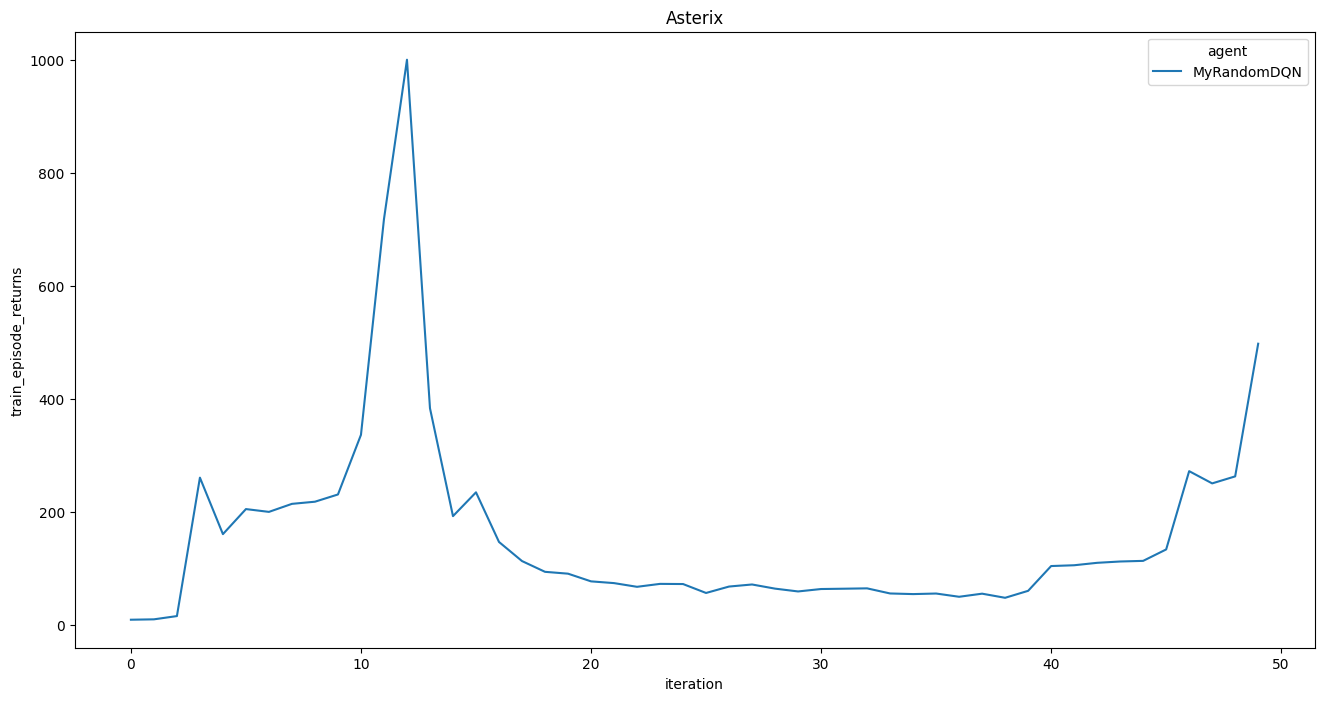

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(
    x='iteration', y='train_episode_returns', hue='agent',
    data=dqn_data, ax=ax)
plt.title(GAME)
plt.grid()
plt.show()